(dp_mix)=
# Dirichlet process mixtures for density estimation

:::{post} Sept 16, 2021
:tags: mixture model, 
:category: advanced
:author: Austin Rochford, Abhipsha Das
:::

## Dirichlet processes

The [Dirichlet process](https://en.wikipedia.org/wiki/Dirichlet_process) is a flexible probability distribution over the space of distributions.  Most generally, a probability distribution, $P$, on a set $\Omega$ is a [measure](https://en.wikipedia.org/wiki/Measure_(mathematics%29) that assigns measure one to the entire space ($P(\Omega) = 1$).  A Dirichlet process $P \sim \textrm{DP}(\alpha, P_0)$ is a measure that has the property that, for every finite [disjoint](https://en.wikipedia.org/wiki/Disjoint_sets) partition $S_1, \ldots, S_n$ of $\Omega$,

$$(P(S_1), \ldots, P(S_n)) \sim \textrm{Dir}(\alpha P_0(S_1), \ldots, \alpha P_0(S_n)).$$

Here $P_0$ is the base probability measure on the space $\Omega$.  The precision parameter $\alpha > 0$ controls how close samples from the Dirichlet process are to the base measure, $P_0$.  As $\alpha \to \infty$, samples from the Dirichlet process approach the base measure $P_0$.

Dirichlet processes have several properties that make them quite suitable to {term}`MCMC` simulation.

1.  The posterior given [i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) observations $\omega_1, \ldots, \omega_n$ from a Dirichlet process $P \sim \textrm{DP}(\alpha, P_0)$ is also a Dirichlet process with

    $$P\ |\ \omega_1, \ldots, \omega_n \sim \textrm{DP}\left(\alpha + n, \frac{\alpha}{\alpha + n} P_0 + \frac{1}{\alpha + n} \sum_{i = 1}^n \delta_{\omega_i}\right),$$
    
 where $\delta$ is the [Dirac delta measure](https://en.wikipedia.org/wiki/Dirac_delta_function)
 
 $$\begin{align*}
     \delta_{\omega}(S)
         & = \begin{cases}
                 1 & \textrm{if } \omega \in S \\
                 0 & \textrm{if } \omega \not \in S
             \end{cases}
 \end{align*}.$$

2. The posterior predictive distribution of a new observation is a compromise between the base measure and the observations,

    $$\omega\ |\ \omega_1, \ldots, \omega_n \sim \frac{\alpha}{\alpha + n} P_0 + \frac{1}{\alpha + n} \sum_{i = 1}^n \delta_{\omega_i}.$$

 We see that the prior precision $\alpha$ can naturally be interpreted as a prior sample size.  The form of this posterior predictive distribution also lends itself to Gibbs sampling.
    
2. Samples, $P \sim \textrm{DP}(\alpha, P_0)$, from a Dirichlet process are discrete with probability one.  That is, there are elements $\omega_1, \omega_2, \ldots$ in $\Omega$ and weights $\mu_1, \mu_2, \ldots$ with $\sum_{i = 1}^{\infty} \mu_i = 1$ such that

    $$P = \sum_{i = 1}^\infty \mu_i \delta_{\omega_i}.$$

3. The [stick-breaking process](https://en.wikipedia.org/wiki/Dirichlet_process#The_stick-breaking_process) gives an explicit construction of the weights $\mu_i$ and samples $\omega_i$ above that is straightforward to sample from.  If $\beta_1, \beta_2, \ldots \sim \textrm{Beta}(1, \alpha)$, then $\mu_i = \beta_i \prod_{j = 1}^{i - 1} (1 - \beta_j)$.  The relationship between this representation and stick breaking may be illustrated as follows:
    1. Start with a stick of length one.
    2. Break the stick into two portions, the first of proportion $\mu_1 = \beta_1$ and the second of proportion $1 - \mu_1$.
    3. Further break the second portion into two portions, the first of proportion $\beta_2$ and the second of proportion $1 - \beta_2$.  The length of the first portion of this stick is $\beta_2 (1 - \beta_1)$; the length of the second portion is $(1 - \beta_1) (1 - \beta_2)$.
    4. Continue breaking the second portion from the previous break in this manner forever.  If $\omega_1, \omega_2, \ldots \sim P_0$, then

    $$P = \sum_{i = 1}^\infty \mu_i \delta_{\omega_i} \sim \textrm{DP}(\alpha, P_0).$$
    
[Suggested Further Reading]: (http://mlg.eng.cam.ac.uk/tutorials/07/ywt.pdf) and {cite:t}`teh2010dirichletprocess` for a brief introduction to other flavours of Dirichlet Processes, and their applications.

We can use the stick-breaking process above to easily sample from a Dirichlet process in Python.  For this example, $\alpha = 2$ and the base distribution is $N(0, 1)$.

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import scipy as sp
import seaborn as sns
import xarray as xr

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
N = 20
K = 30

alpha = 2.0
P0 = sp.stats.norm

We draw and plot samples from the stick-breaking process.

In [4]:
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

x_plot = xr.DataArray(np.linspace(-3, 3, 200), dims=["plot"])

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot.values)).sum(axis=1)

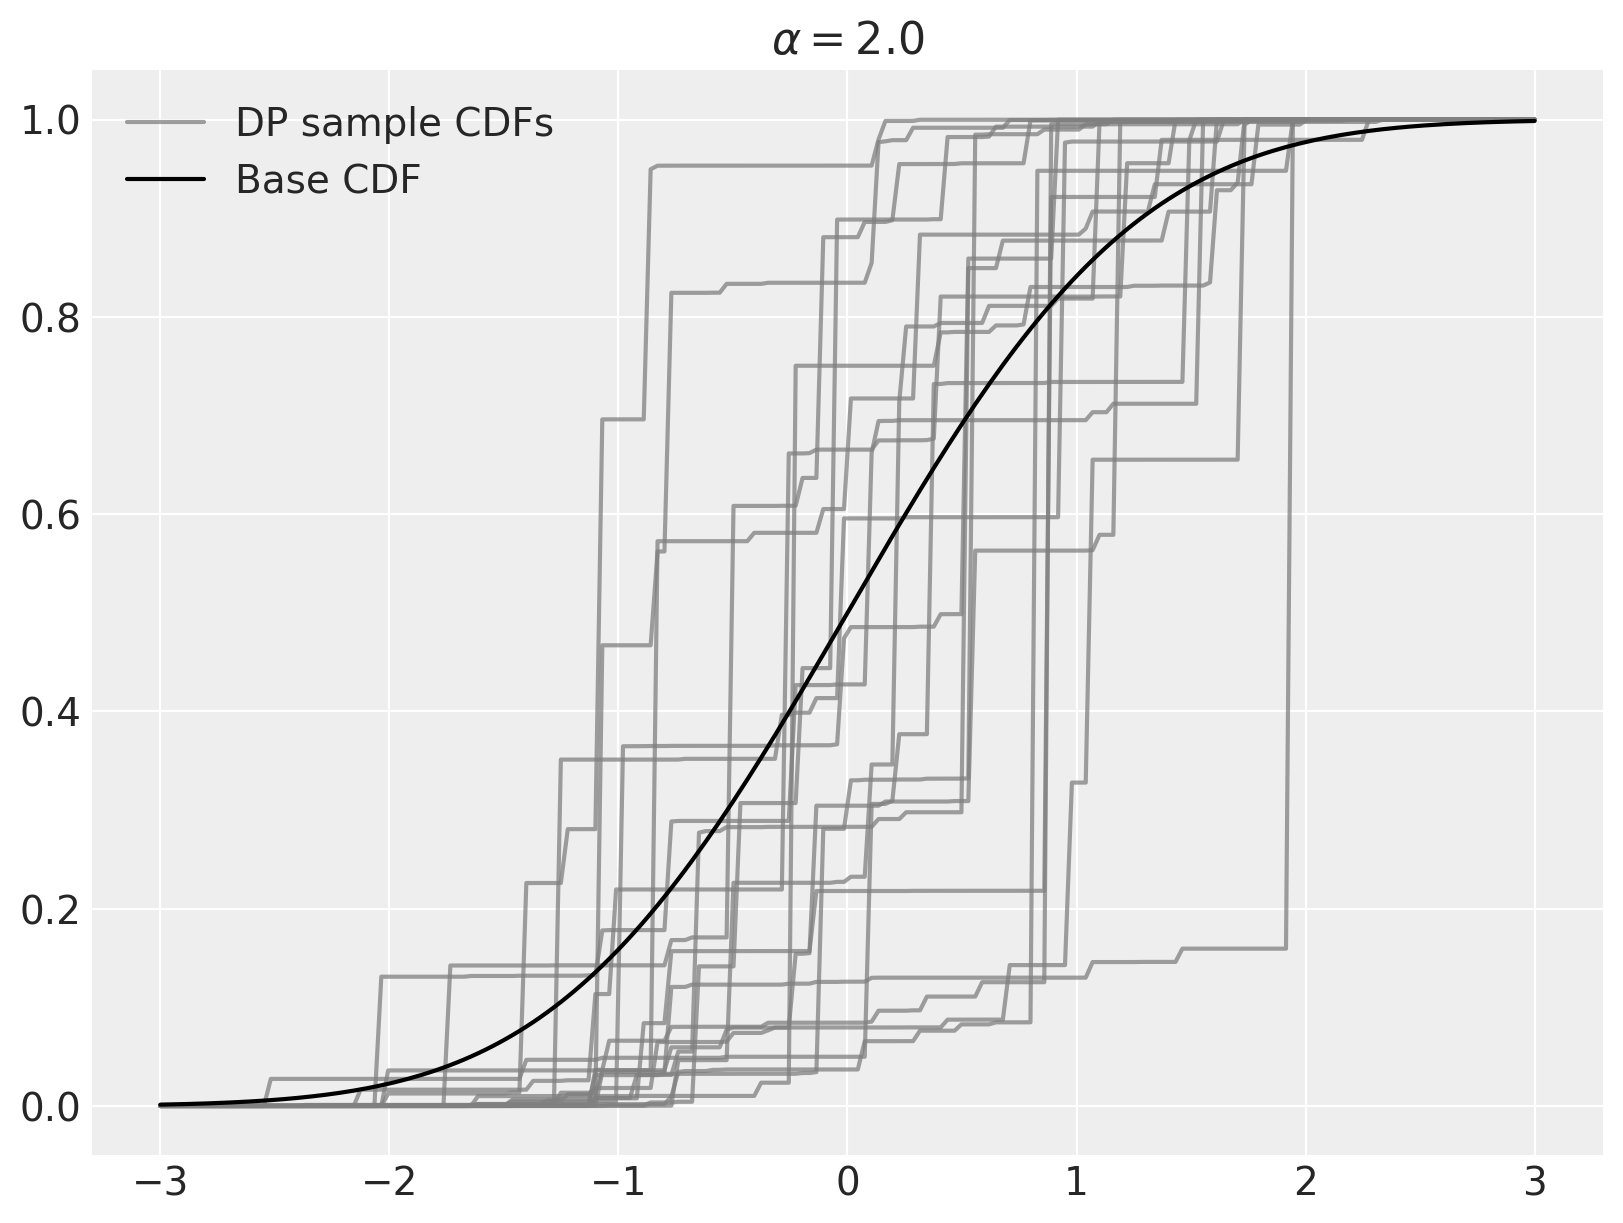

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, sample_cdfs[0], c="gray", alpha=0.75, label="DP sample CDFs")
ax.plot(x_plot, sample_cdfs[1:].T, c="gray", alpha=0.75)
ax.plot(x_plot, P0.cdf(x_plot), c="k", label="Base CDF")

ax.set_title(rf"$\alpha = {alpha}$")
ax.legend(loc=2);

As stated above, as $\alpha \to \infty$, samples from the Dirichlet process converge to the base distribution.

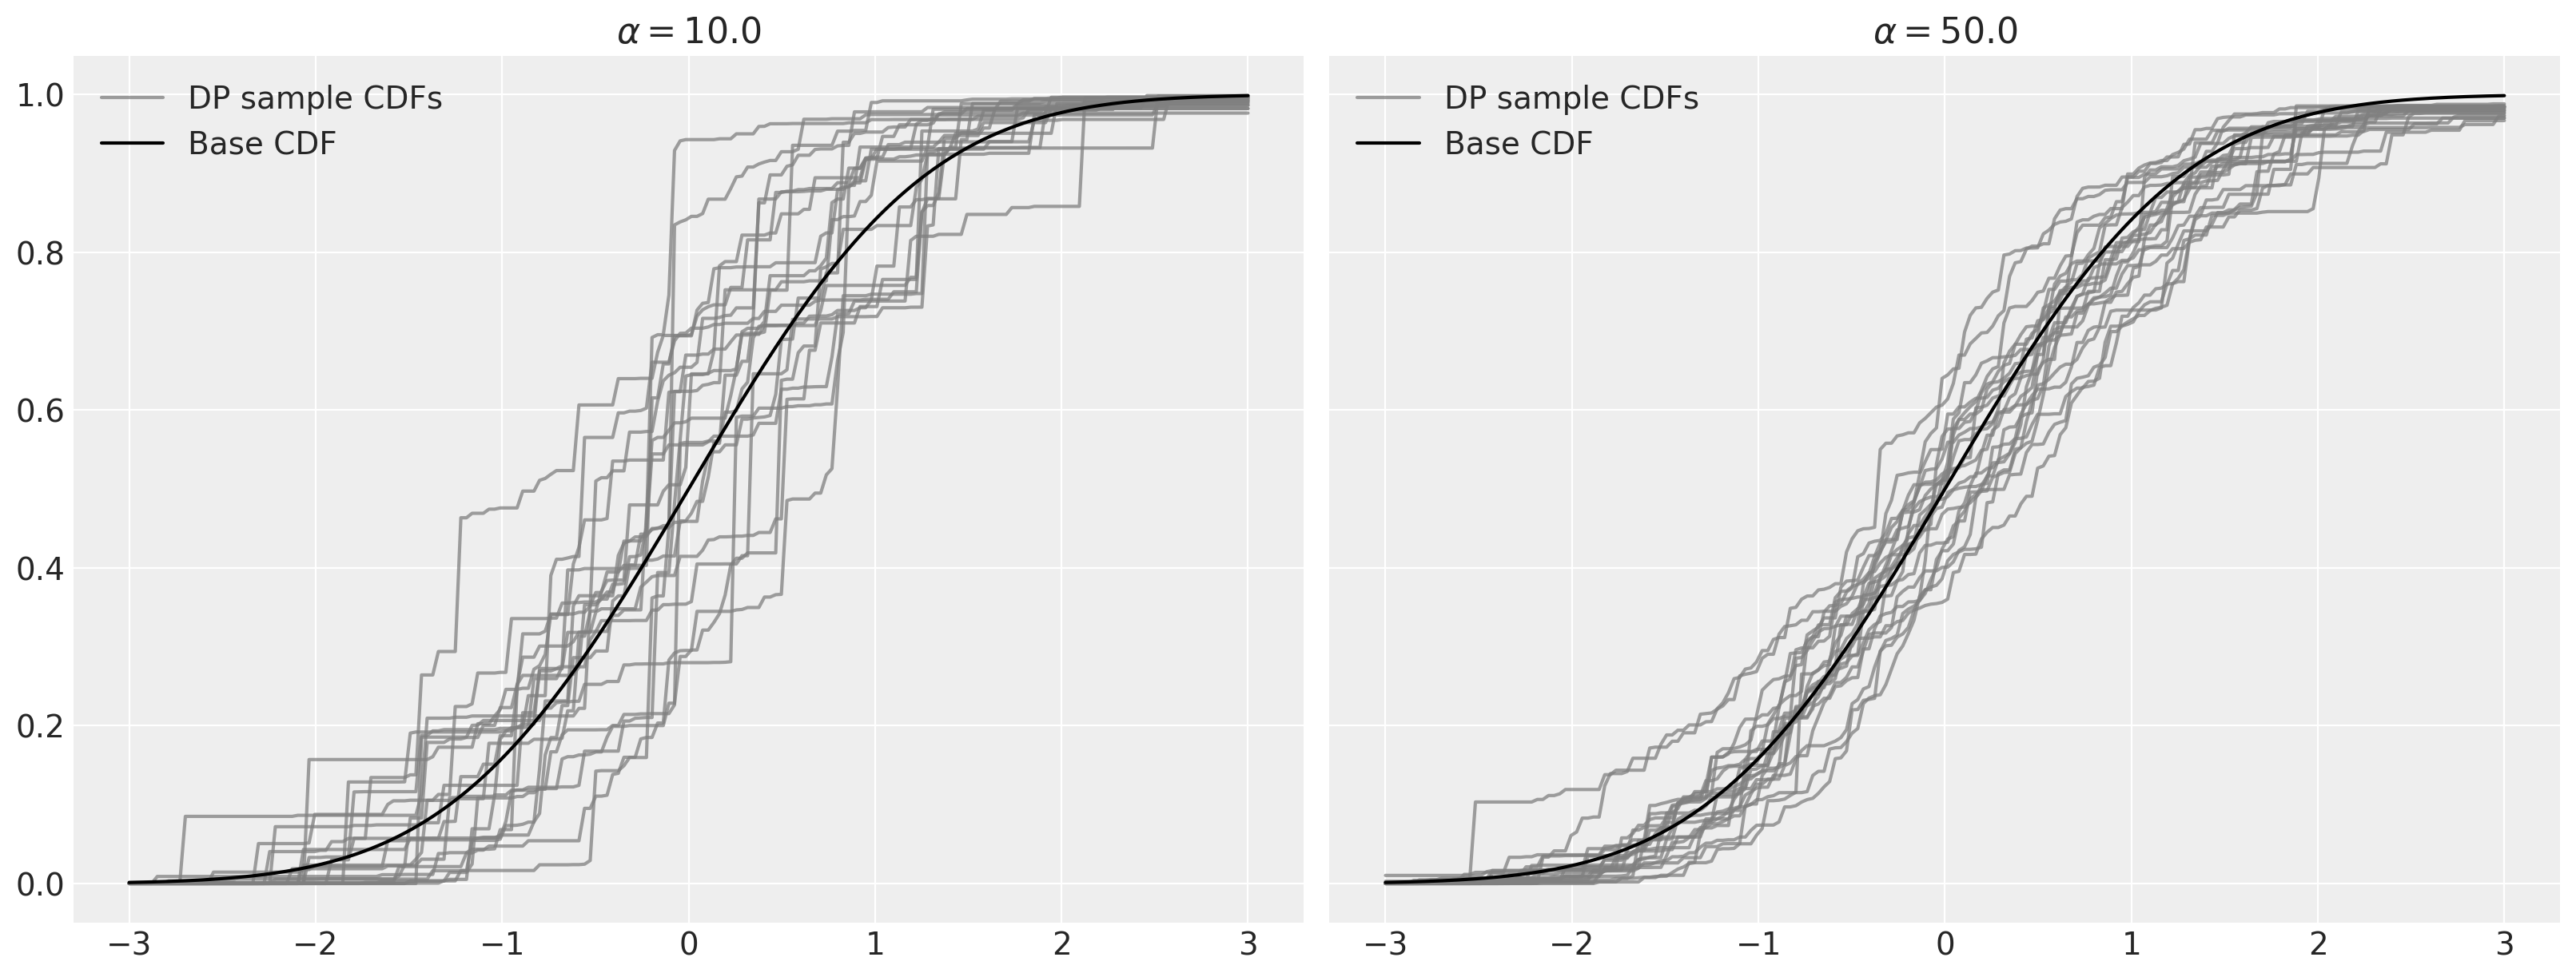

In [6]:
fig, (l_ax, r_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

K = 50
alpha = 10.0

beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot.values)).sum(axis=1)

l_ax.plot(x_plot, sample_cdfs[0], c="gray", alpha=0.75, label="DP sample CDFs")
l_ax.plot(x_plot, sample_cdfs[1:].T, c="gray", alpha=0.75)
l_ax.plot(x_plot, P0.cdf(x_plot), c="k", label="Base CDF")

l_ax.set_title(rf"$\alpha = {alpha}$")
l_ax.legend(loc=2)

K = 200
alpha = 50.0

beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot.values)).sum(axis=1)

r_ax.plot(x_plot, sample_cdfs[0], c="gray", alpha=0.75, label="DP sample CDFs")
r_ax.plot(x_plot, sample_cdfs[1:].T, c="gray", alpha=0.75)
r_ax.plot(x_plot, P0.cdf(x_plot), c="k", label="Base CDF")

r_ax.set_title(rf"$\alpha = {alpha}$")
r_ax.legend(loc=2);

## Dirichlet process mixtures

For the task of density estimation, the (almost sure) discreteness of samples from the Dirichlet process is a significant drawback.  This problem can be solved with another level of indirection by using Dirichlet process mixtures for density estimation.  A Dirichlet process mixture uses component densities from a parametric family $\mathcal{F} = \{f_{\theta}\ |\ \theta \in \Theta\}$ and represents the mixture weights as a Dirichlet process.  If $P_0$ is a probability measure on the parameter space $\Theta$, a Dirichlet process mixture is the hierarchical model

$$
\begin{align*}
    x_i\ |\ \theta_i
        & \sim f_{\theta_i} \\
    \theta_1, \ldots, \theta_n
        & \sim P \\
    P
        & \sim \textrm{DP}(\alpha, P_0).
\end{align*}
$$

To illustrate this model, we simulate draws from a Dirichlet process mixture with $\alpha = 2$, $\theta \sim N(0, 1)$, $x\ |\ \theta \sim N(\theta, (0.3)^2)$.

In [7]:
N = 5
K = 30

alpha = 2
P0 = sp.stats.norm
f = lambda x, theta: sp.stats.norm.pdf(x, theta, 0.3)

In [8]:
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

theta = P0.rvs(size=(N, K))

dpm_pdf_components = f(x_plot, theta[..., np.newaxis])
dpm_pdfs = (w[..., np.newaxis] * dpm_pdf_components).sum(axis=1)

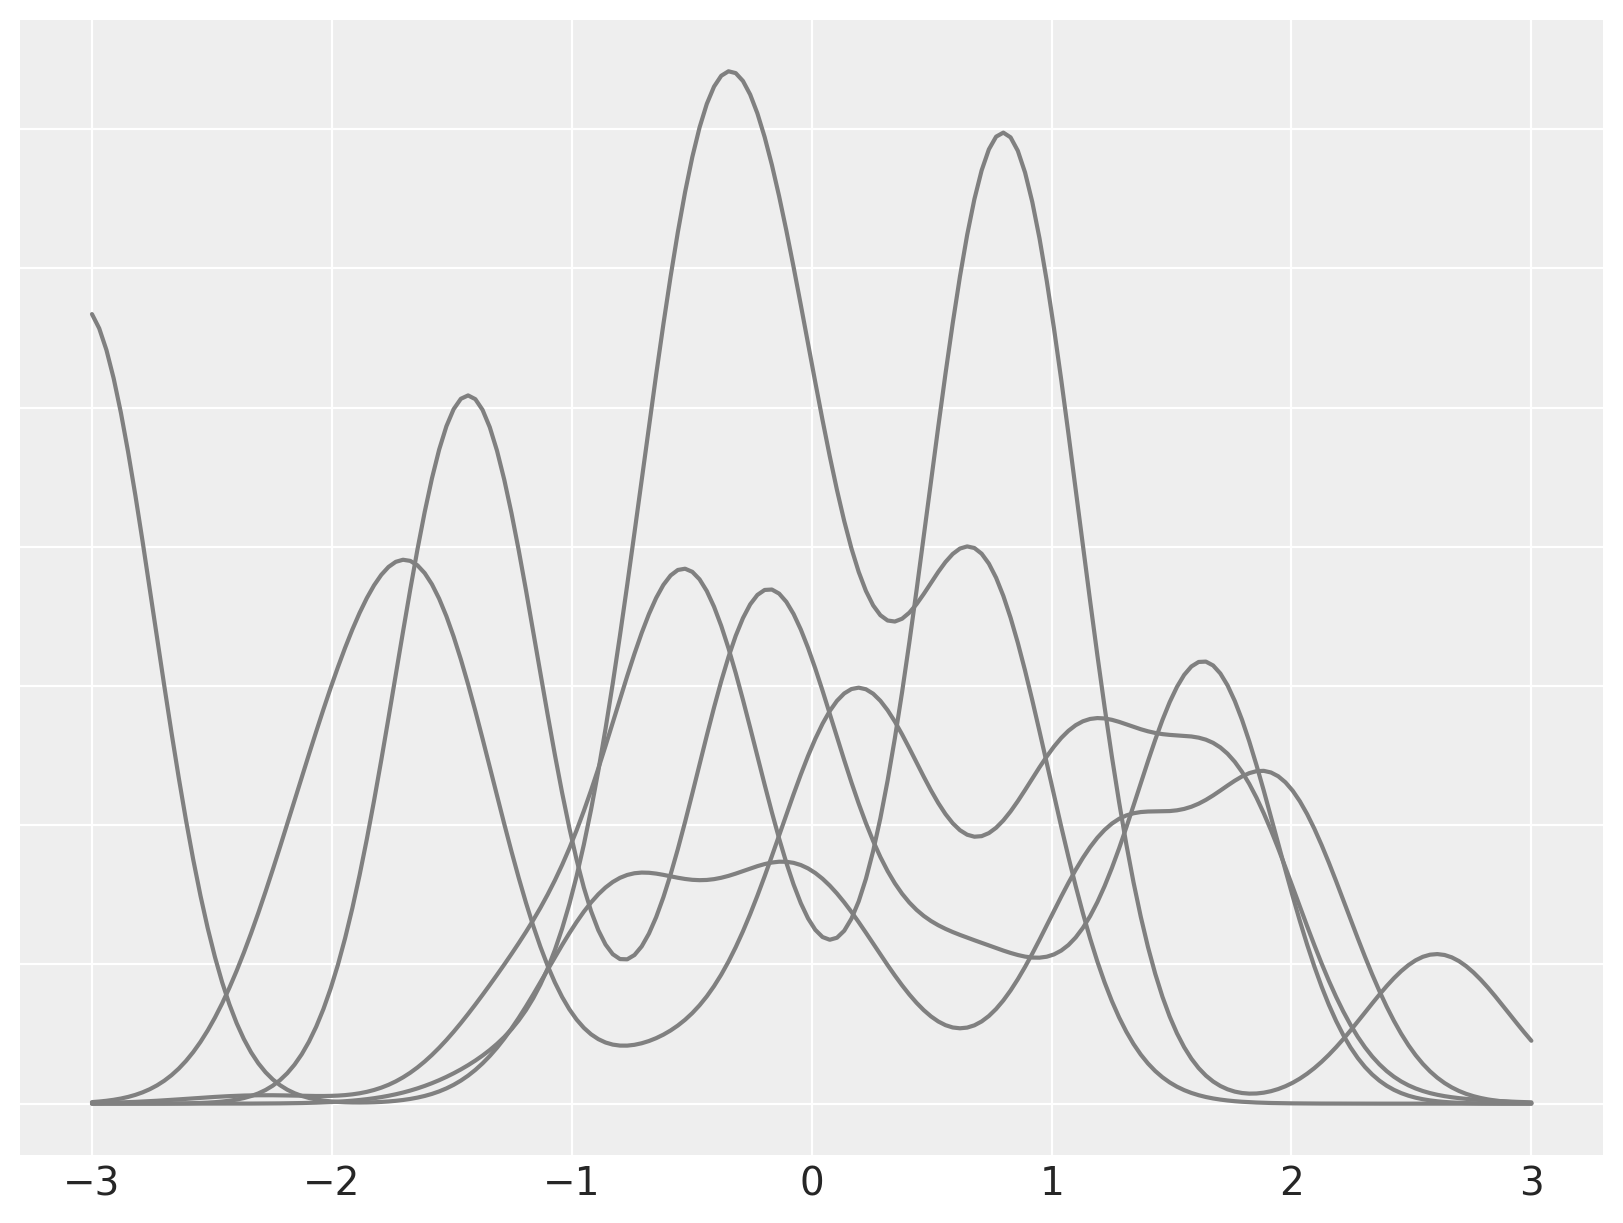

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, dpm_pdfs.T, c="gray")

ax.set_yticklabels([]);

We now focus on a single mixture and decompose it into its individual (weighted) mixture components.

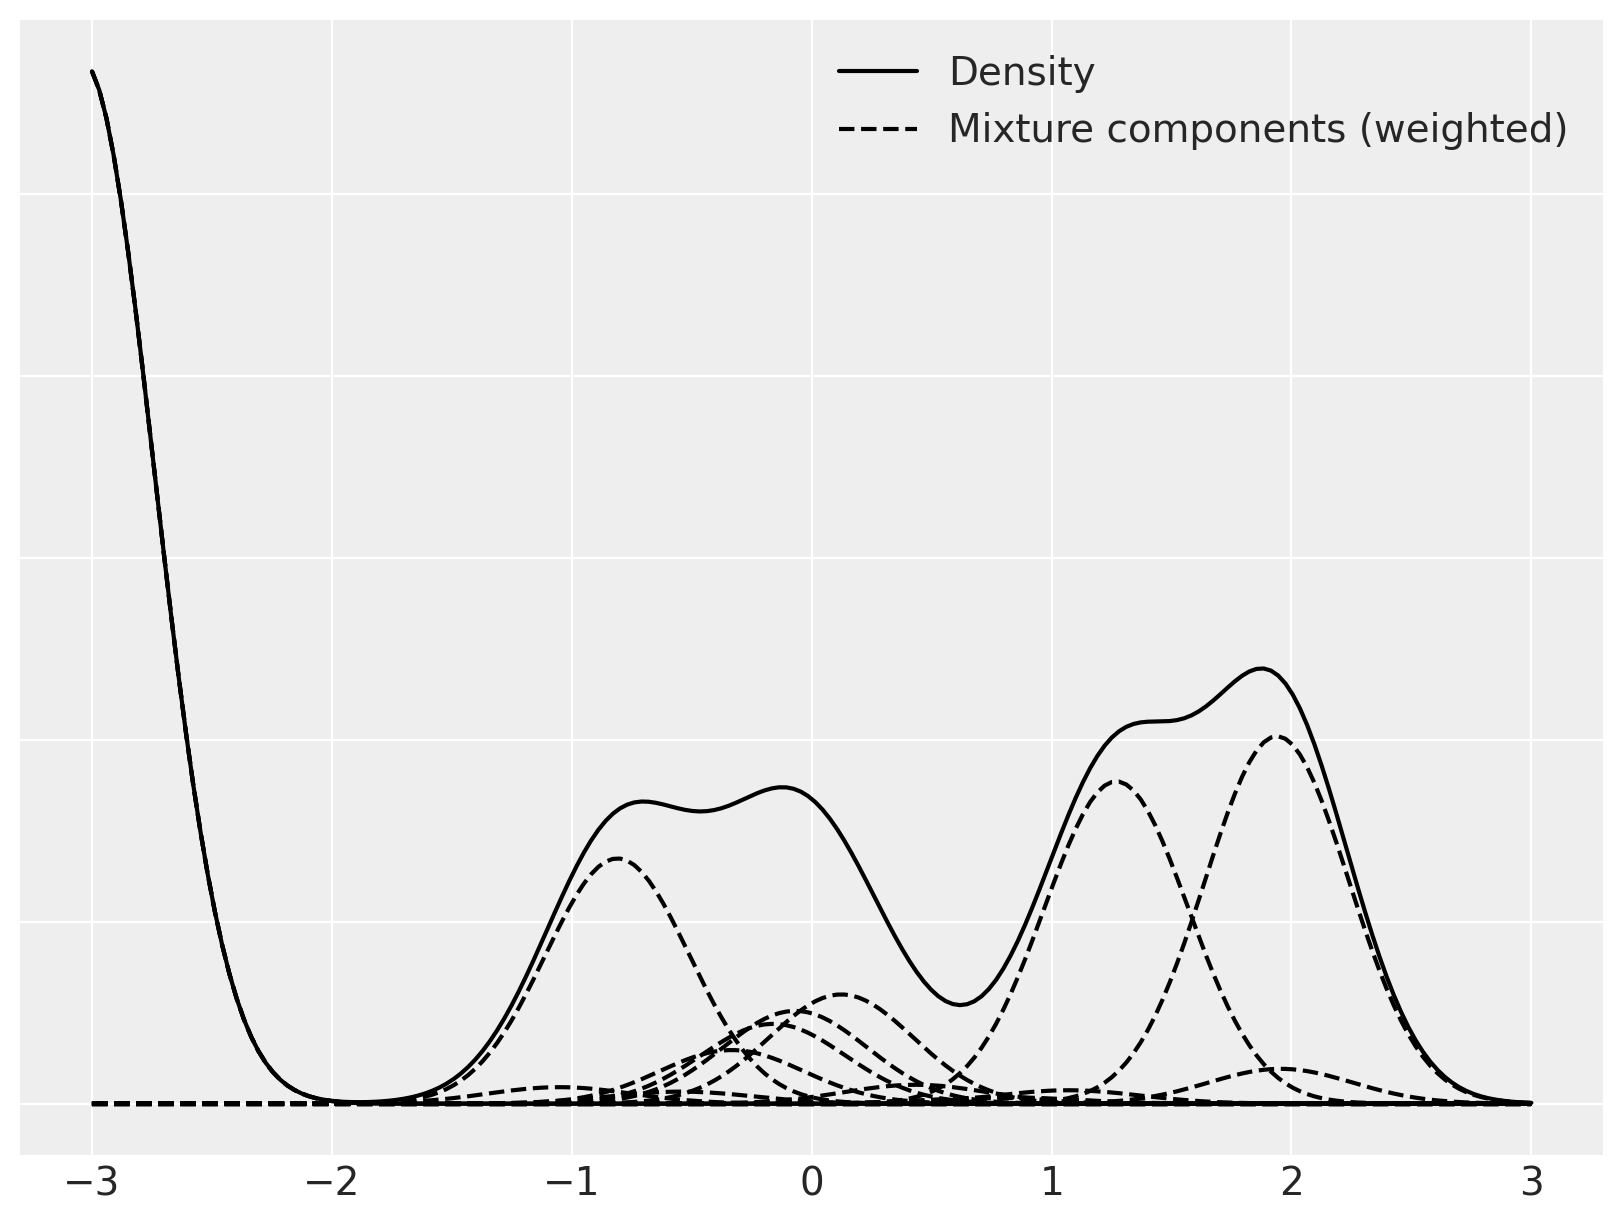

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

ix = 1

ax.plot(x_plot, dpm_pdfs[ix], c="k", label="Density")
ax.plot(
    x_plot,
    (w[..., np.newaxis] * dpm_pdf_components)[ix, 0],
    "--",
    c="k",
    label="Mixture components (weighted)",
)
ax.plot(x_plot, (w[..., np.newaxis] * dpm_pdf_components)[ix].T, "--", c="k")

ax.set_yticklabels([])
ax.legend(loc=1);

Sampling from these stochastic processes is fun, but these ideas become truly useful when we fit them to data.  The discreteness of samples and the stick-breaking representation of the Dirichlet process lend themselves nicely to Markov chain Monte Carlo simulation of posterior distributions.  We will perform this sampling using `PyMC`.

Our first example uses a Dirichlet process mixture to estimate the density of waiting times between eruptions of the [Old Faithful](https://en.wikipedia.org/wiki/Old_Faithful) geyser in [Yellowstone National Park](https://en.wikipedia.org/wiki/Yellowstone_National_Park).

In [11]:
try:
    old_faithful_df = pd.read_csv(os.path.join("..", "data", "old_faithful.csv"))
except FileNotFoundError:
    old_faithful_df = pd.read_csv(pm.get_data("old_faithful.csv"))

For convenience in specifying the prior, we standardize the waiting time between eruptions.

In [12]:
old_faithful_df["std_waiting"] = (
    old_faithful_df.waiting - old_faithful_df.waiting.mean()
) / old_faithful_df.waiting.std()

In [13]:
old_faithful_df.head()

,eruptions,waiting,std_waiting
0,3.600,79,0.596025
1,1.800,54,-1.242890
2,3.333,74,0.228242
3,2.283,62,-0.654437
4,4.533,85,1.037364


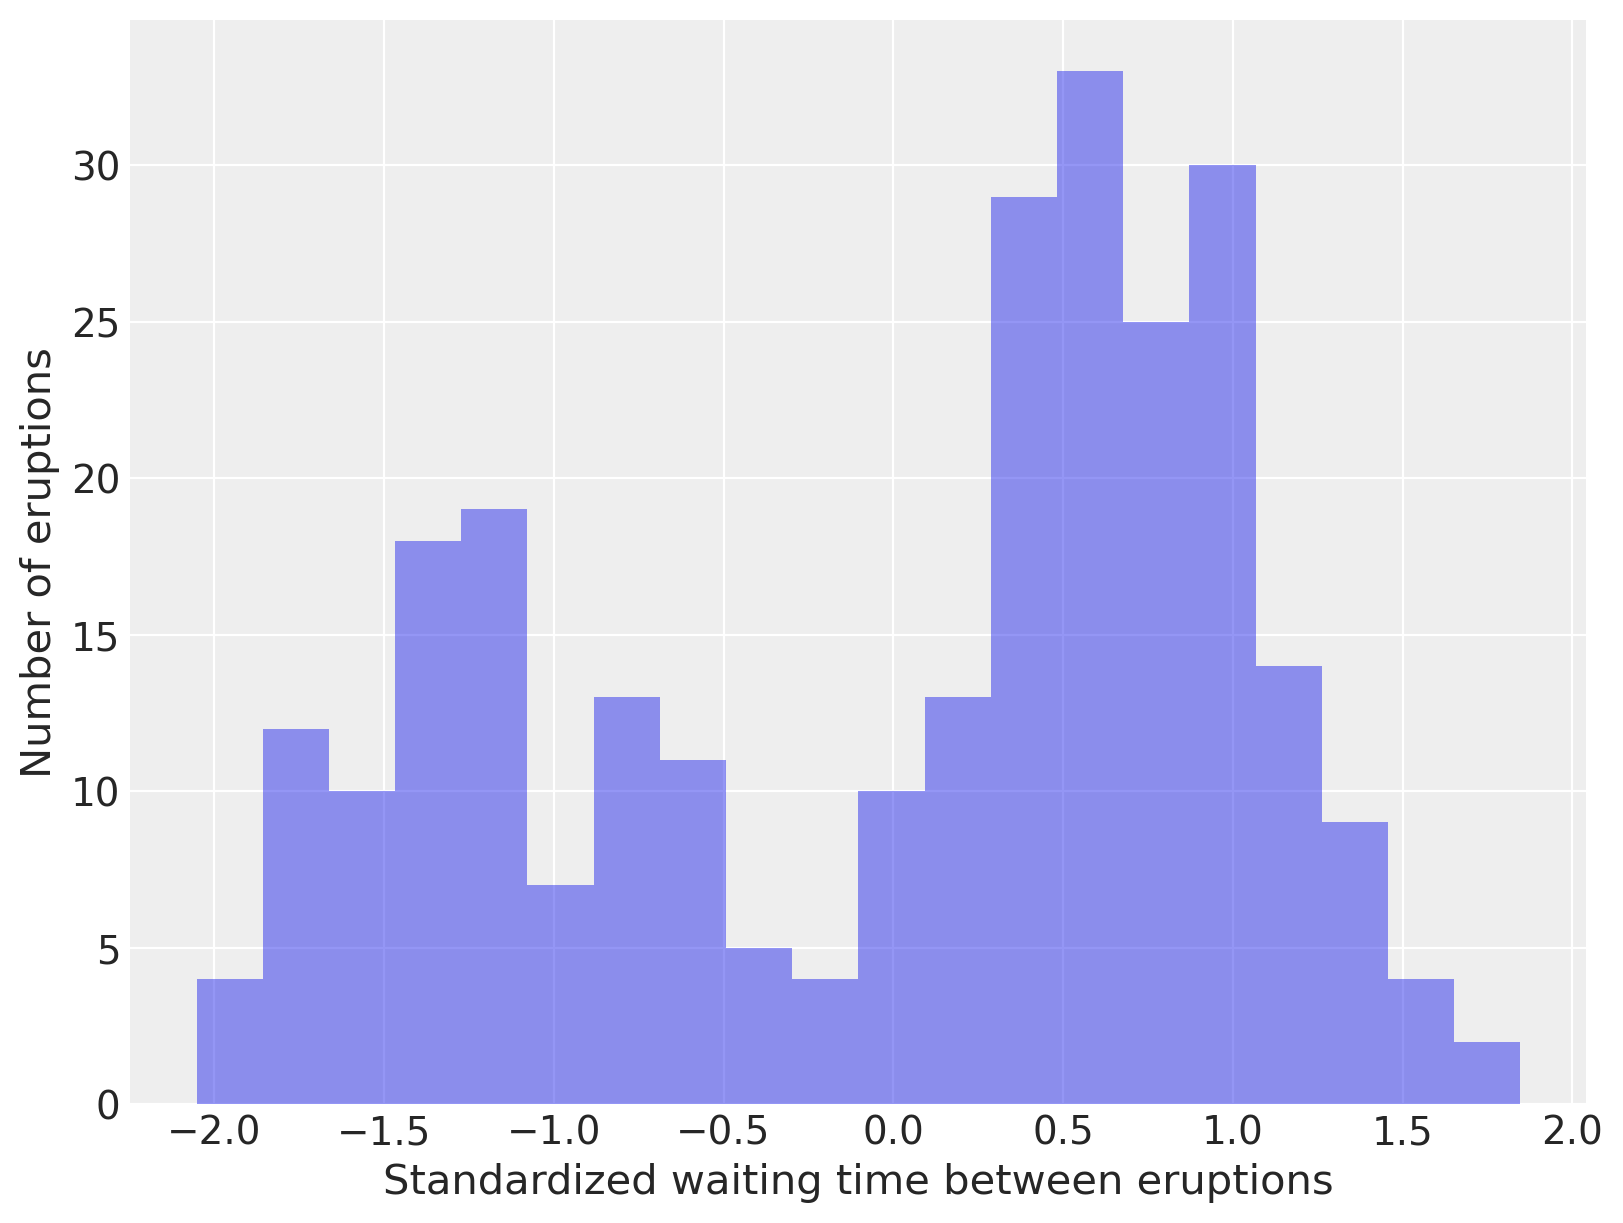

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(old_faithful_df.std_waiting, bins=n_bins, color="C0", lw=0, alpha=0.5)

ax.set_xlabel("Standardized waiting time between eruptions")
ax.set_ylabel("Number of eruptions");

Observant readers will have noted that we have not been continuing the stick-breaking process indefinitely as indicated by its definition, but rather have been truncating this process after a finite number of breaks.  Obviously, when computing with Dirichlet processes, it is necessary to only store a finite number of its point masses and weights in memory.  This restriction is not terribly onerous, since with a finite number of observations, it seems quite likely that the number of mixture components that contribute non-negligible mass to the mixture will grow slower than the number of samples.  This intuition can be formalized to show that the (expected) number of components that contribute non-negligible mass to the mixture approaches $\alpha \log N$, where $N$ is the sample size.

There are various clever [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) techniques for Dirichlet processes that allow the number of components stored to grow as needed.  Stochastic memoization {cite:p}`roy2008npbayes` is another powerful technique for simulating Dirichlet processes while only storing finitely many components in memory.  In this introductory example, we take the much less sophisticated approach of simply truncating the Dirichlet process components that are stored after a fixed number, $K$, of components. {cite:t}`ishwaran2002approxdirichlet` and {cite:t}`ohlssen2007flexible` provide justification for truncation, showing that $K > 5 \alpha + 2$ is most likely sufficient to capture almost all of the mixture weight ($\sum_{i = 1}^{K} w_i > 0.99$).  In practice, we can verify the suitability of our truncated approximation to the Dirichlet process by checking the number of components that contribute non-negligible mass to the mixture.  If, in our simulations, all components contribute non-negligible mass to the mixture, we have truncated the Dirichlet process too early.

Our (truncated) Dirichlet process mixture model for the standardized waiting times is

$$
\begin{align*}
    \alpha
        & \sim \textrm{Gamma}(1, 1) \\
    \beta_1, \ldots, \beta_K
        & \sim \textrm{Beta}(1, \alpha) \\
    w_i
        & = \beta_i \prod_{j = i - 1}^i (1 - \beta_j) \\
    \\
    \lambda_1, \ldots, \lambda_K
        & \sim \textrm{Gamma}(10, 1) \\
    \tau_1, \ldots, \tau_K
        & \sim \textrm{Gamma}(10, 1) \\
    \mu_i\ |\ \lambda_i, \tau_i
        & \sim N\left(0, (\lambda_i \tau_i)^{-1}\right) \\
    \\
    x\ |\ w_i, \lambda_i, \tau_i, \mu_i
        & \sim \sum_{i = 1}^K w_i\ N(\mu_i, (\lambda_i \tau_i)^{-1})
\end{align*}
$$

Note that instead of fixing a value of $\alpha$, as in our previous simulations, we specify a prior on $\alpha$, so that we may learn its posterior distribution from the observations.

We now construct this model using `PyMC`.

In [15]:
N = old_faithful_df.shape[0]
K = 30

In [16]:
def stick_breaking(beta):
    portion_remaining = pt.concatenate([[1], pt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [17]:
with pm.Model(coords={"component": np.arange(K), "obs_id": np.arange(N)}) as model:
    alpha = pm.Gamma("alpha", 1.0, 1.0)
    beta = pm.Beta("beta", 1.0, alpha, dims="component")
    w = pm.Deterministic("w", stick_breaking(beta), dims="component")

    tau = pm.Gamma("tau", 1.0, 1.0, dims="component")
    lambda_ = pm.Gamma("lambda_", 10.0, 1.0, dims="component")
    mu = pm.Normal("mu", 0, tau=lambda_ * tau, dims="component")
    obs = pm.NormalMixture(
        "obs", w, mu, tau=lambda_ * tau, observed=old_faithful_df.std_waiting.values, dims="obs_id"
    )

We sample from the model 1,000 times using NUTS initialized with ADVI.

In [18]:
with model:
    trace = pm.sample(
        tune=2500,
        init="advi",
        target_accept=0.975,
        random_seed=RANDOM_SEED,
    )

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 127 seconds.


The posterior distribution of $\alpha$ is highly concentrated between 0.25 and 1.

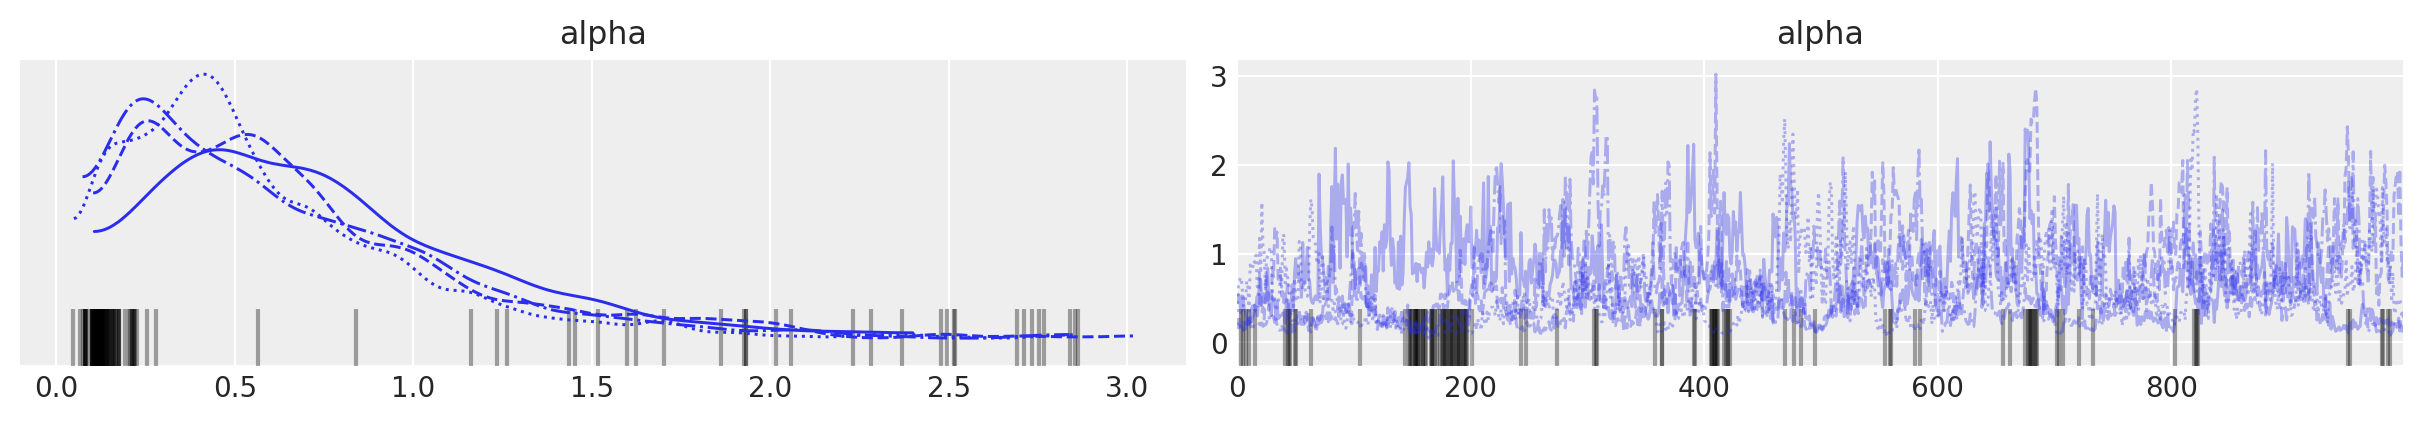

In [19]:
az.plot_trace(trace, var_names=["alpha"]);

To verify that truncation is not biasing our results, we plot the posterior expected mixture weight of each component.

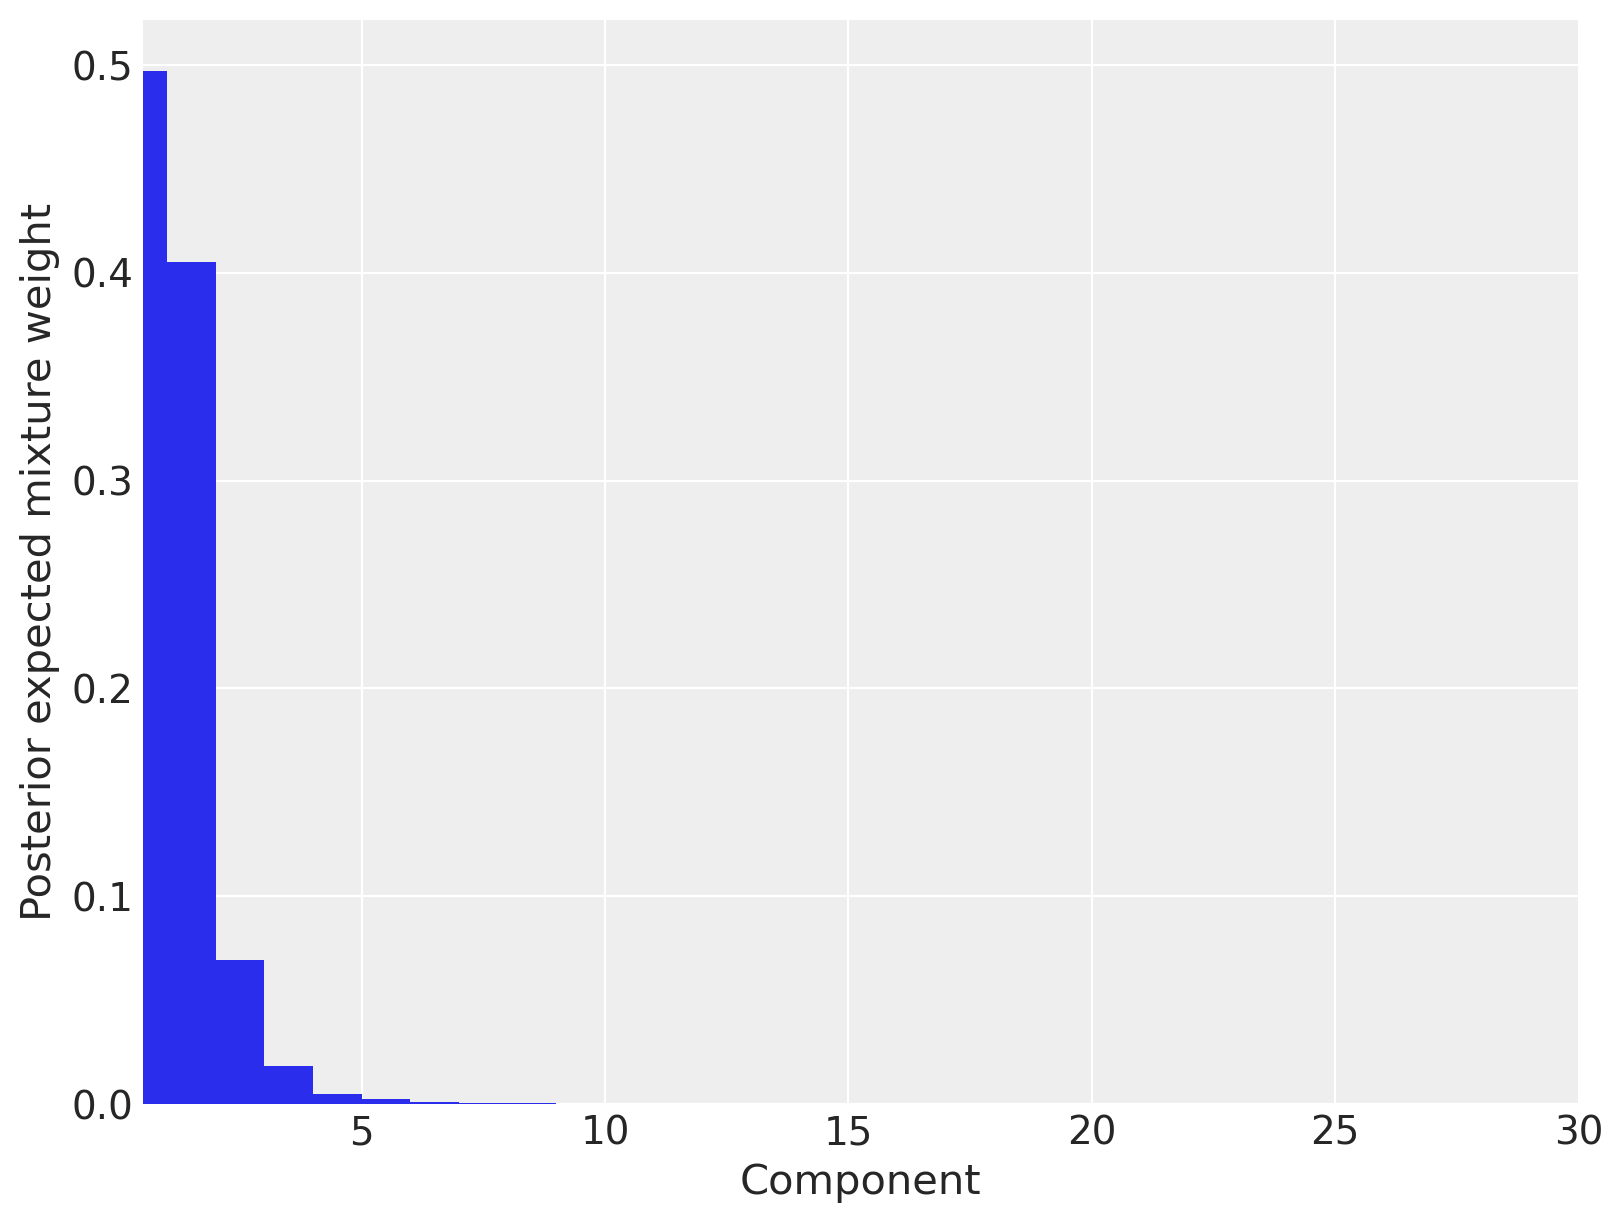

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1

ax.bar(plot_w - 0.5, trace.posterior["w"].mean(("chain", "draw")), width=1.0, lw=0)

ax.set_xlim(0.5, K)
ax.set_xlabel("Component")

ax.set_ylabel("Posterior expected mixture weight");

We see that only three mixture components have appreciable posterior expected weights, so we conclude that truncating the Dirichlet process to thirty components has not appreciably affected our estimates.

We now compute and plot our posterior density estimate.

In [21]:
post_pdf_contribs = xr.apply_ufunc(
    sp.stats.norm.pdf,
    x_plot,
    trace.posterior["mu"],
    1.0 / np.sqrt(trace.posterior["lambda_"] * trace.posterior["tau"]),
)

post_pdfs = (trace.posterior["w"] * post_pdf_contribs).sum(dim=("component"))

post_pdf_quantiles = post_pdfs.quantile([0.1, 0.9], dim=("chain", "draw"))

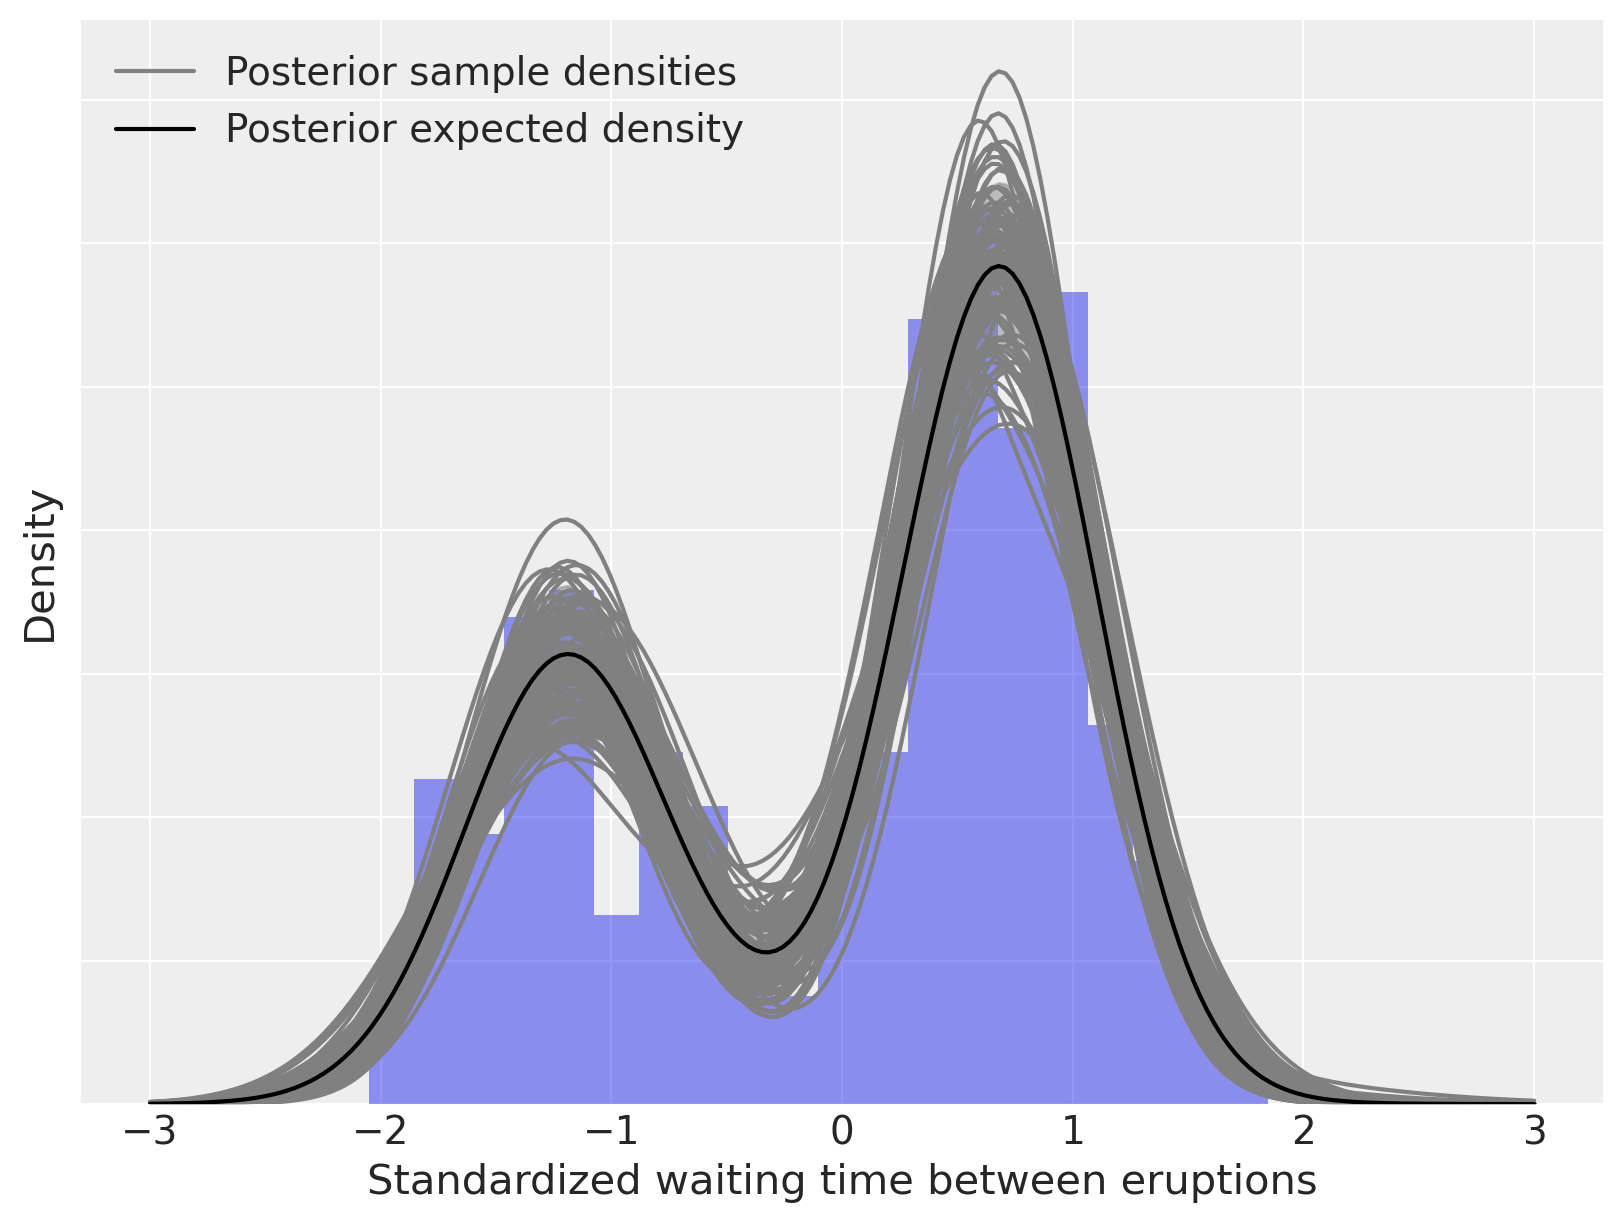

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(old_faithful_df.std_waiting.values, bins=n_bins, density=True, color="C0", lw=0, alpha=0.5)

ax.fill_between(
    x_plot,
    post_pdf_quantiles.sel(quantile=0.1),
    post_pdf_quantiles.sel(quantile=0.9),
    color="gray",
    alpha=0.45,
)
ax.plot(x_plot, post_pdfs.sel(chain=0, draw=0), c="gray", label="Posterior sample densities")
ax.plot(
    x_plot,
    az.extract(post_pdfs, var_names="x", num_samples=100),
    c="gray",
)
ax.plot(x_plot, post_pdfs.mean(dim=("chain", "draw")), c="k", label="Posterior expected density")

ax.set_xlabel("Standardized waiting time between eruptions")

ax.set_yticklabels([])
ax.set_ylabel("Density")

ax.legend(loc=2);

As above, we can decompose this density estimate into its (weighted) mixture components.

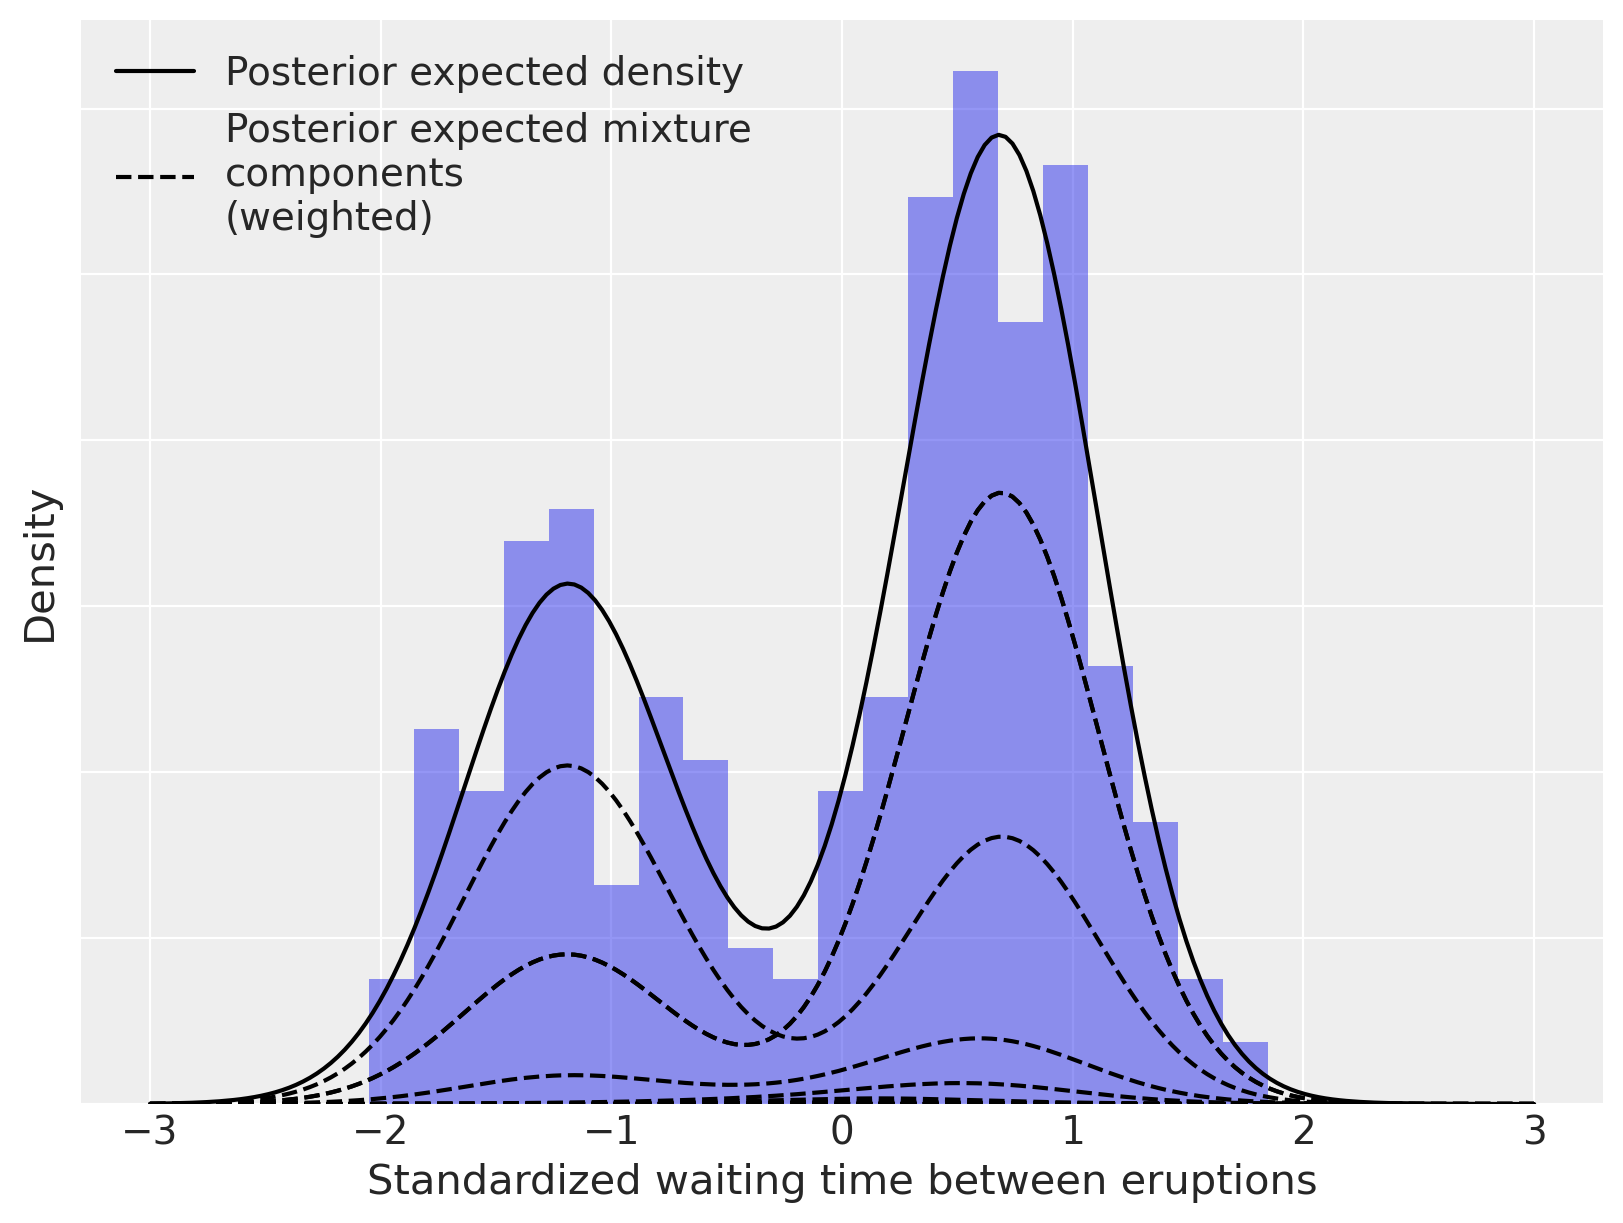

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(old_faithful_df.std_waiting.values, bins=n_bins, density=True, color="C0", lw=0, alpha=0.5)

ax.plot(x_plot, post_pdfs.mean(dim=("chain", "draw")), c="k", label="Posterior expected density")
ax.plot(
    x_plot,
    (trace.posterior["w"] * post_pdf_contribs).mean(dim=("chain", "draw")).sel(component=0),
    "--",
    c="k",
    label="Posterior expected mixture\ncomponents\n(weighted)",
)
ax.plot(
    x_plot,
    (trace.posterior["w"] * post_pdf_contribs).mean(dim=("chain", "draw")).T,
    "--",
    c="k",
)

ax.set_xlabel("Standardized waiting time between eruptions")

ax.set_yticklabels([])
ax.set_ylabel("Density")

ax.legend(loc=2);

The Dirichlet process mixture model is incredibly flexible in terms of the family of parametric component distributions $\{f_{\theta}\ |\ f_{\theta} \in \Theta\}$.  We illustrate this flexibility below by using Poisson component distributions to estimate the density of sunspots per year. This dataset was curated by {cite:t}`sidc2021sunspot` and can be downloaded.

In [24]:
kwargs = dict(sep=";", names=["time", "sunspot.year"], usecols=[0, 1])
try:
    sunspot_df = pd.read_csv(os.path.join("..", "data", "sunspot.csv"), **kwargs)
except FileNotFoundError:
    sunspot_df = pd.read_csv(pm.get_data("sunspot.csv"), **kwargs)

In [25]:
sunspot_df.head()

,time,sunspot.year
0,1700.5,8.3
1,1701.5,18.3
2,1702.5,26.7
3,1703.5,38.3
4,1704.5,60.0


For this example, the model is

$$
\begin{align*}
    \alpha
        & \sim \textrm{Gamma}(1, 1) \\
    \beta_1, \ldots, \beta_K
        & \sim \textrm{Beta}(1, \alpha) \\
    w_i
        & = \beta_i \prod_{j = i - 1}^i (1 - \beta_j) \\
    \\
    \lambda_i, \ldots, \lambda_K
        & \sim \textrm{Gamma}(300, 2)
    \\
    x\ |\ w_i, \lambda_i
        & \sim \sum_{i = 1}^K w_i\ \textrm{Poisson}(\lambda_i).
\end{align*}
$$

In [26]:
K = 50
N = sunspot_df.shape[0]

In [27]:
with pm.Model(coords={"component": np.arange(K), "obs_id": np.arange(N)}) as model:
    alpha = pm.Gamma("alpha", 1.0, 1.0)
    beta = pm.Beta("beta", 1, alpha, dims="component")
    w = pm.Deterministic("w", stick_breaking(beta), dims="component")
    # Gamma is conjugate prior to Poisson
    lambda_ = pm.Gamma("lambda_", 300.0, 2.0, dims="component")
    obs = pm.Mixture(
        "obs", w, pm.Poisson.dist(lambda_), observed=sunspot_df["sunspot.year"], dims="obs_id"
    )

In [28]:
with model:
    trace = pm.sample(
        tune=5000,
        init="advi",
        target_accept=0.95,
        random_seed=RANDOM_SEED,
    )

Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 508 seconds.


For the sunspot model, the posterior distribution of $\alpha$ is concentrated between 0.6 and 1.2, indicating that we should expect more components to contribute non-negligible amounts to the mixture than for the Old Faithful waiting time model.

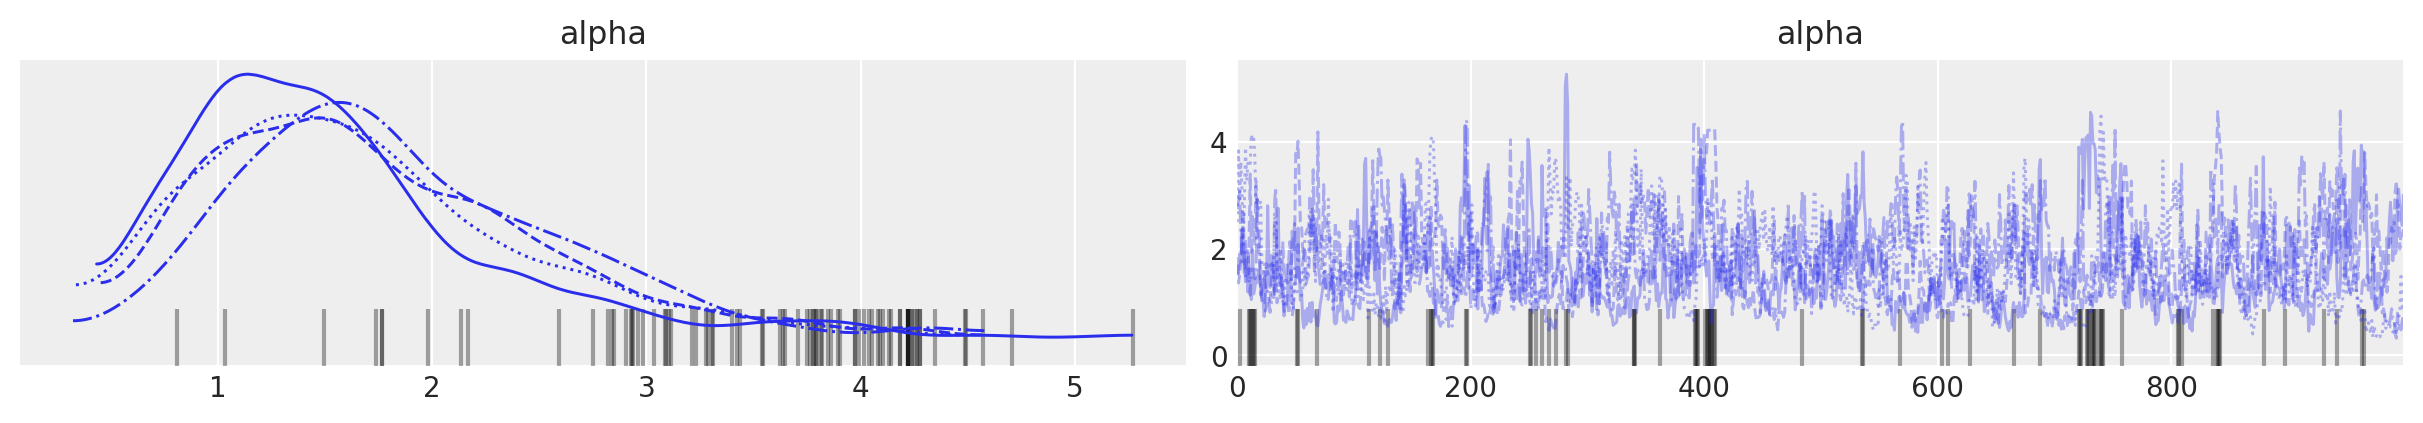

In [29]:
az.plot_trace(trace, var_names=["alpha"]);

Indeed, we see that between ten and fifteen mixture components have appreciable posterior expected weight.

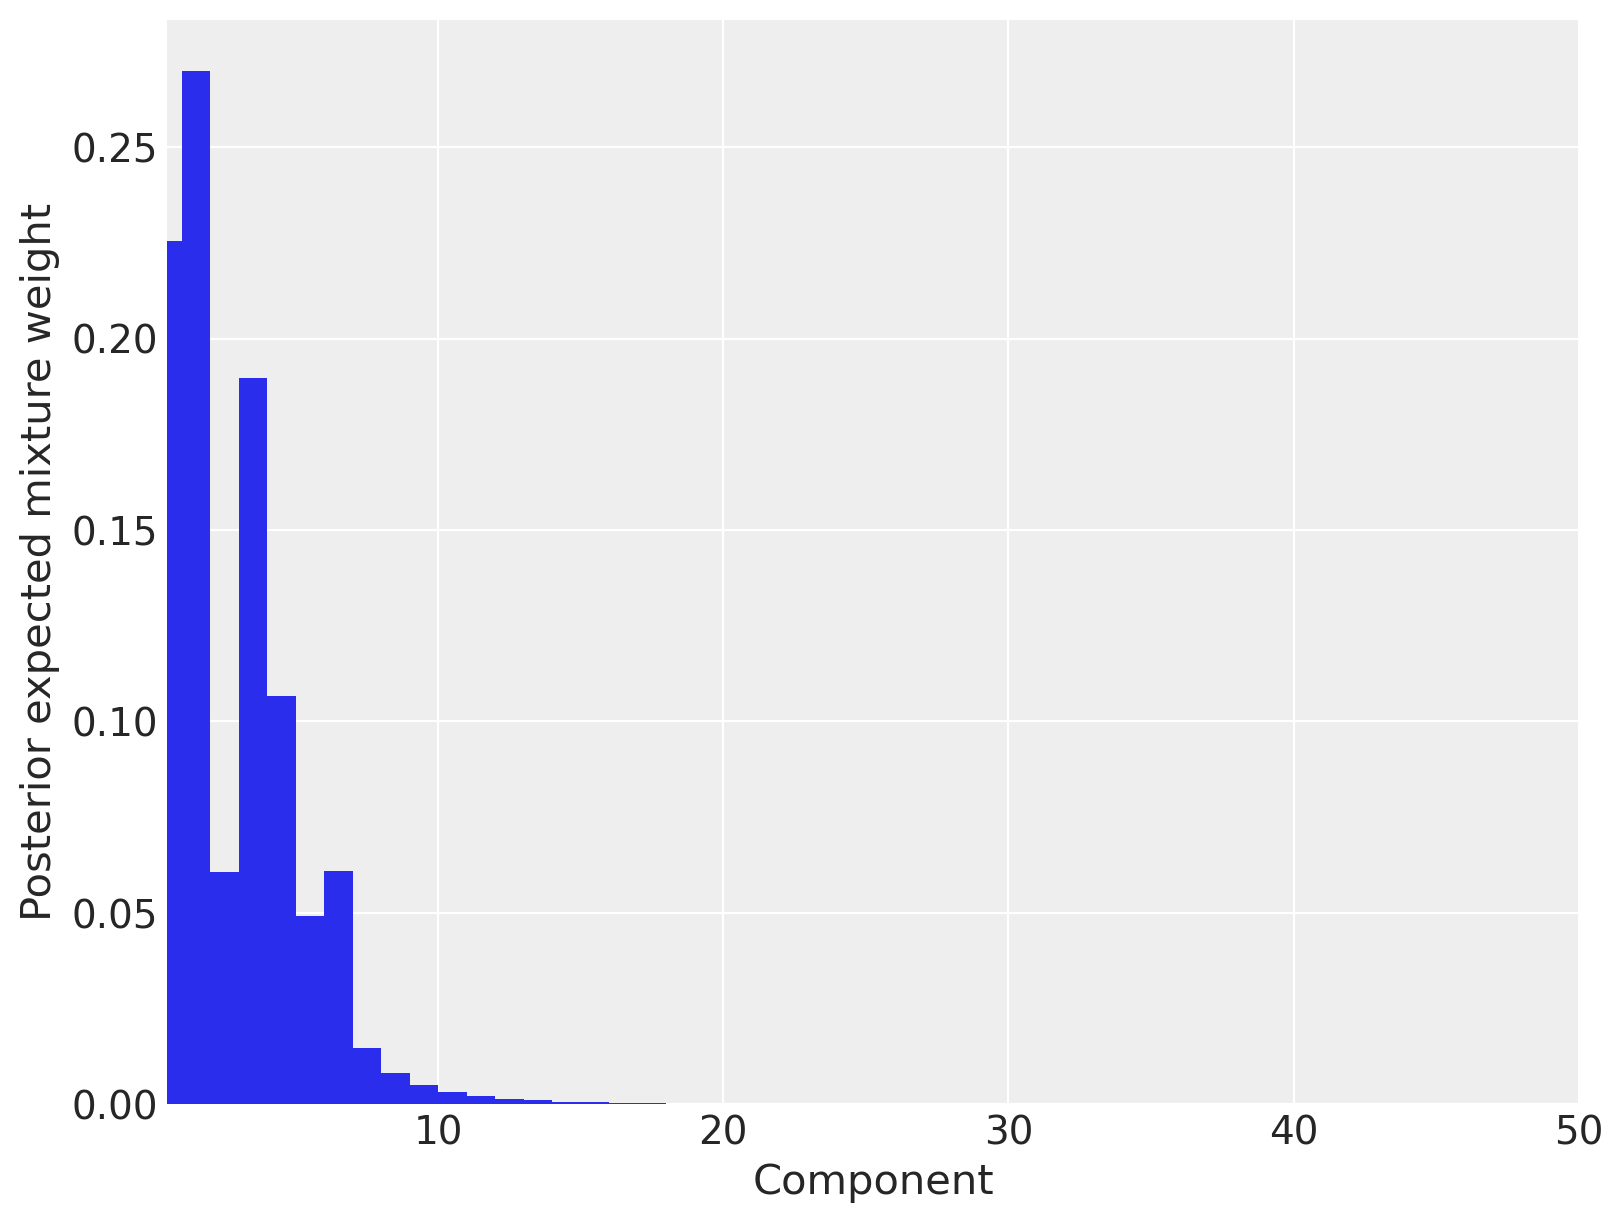

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1

ax.bar(plot_w - 0.5, trace.posterior["w"].mean(("chain", "draw")), width=1.0, lw=0)

ax.set_xlim(0.5, K)
ax.set_xlabel("Component")

ax.set_ylabel("Posterior expected mixture weight");

We now calculate and plot the fitted density estimate.

In [31]:
x_plot = xr.DataArray(np.arange(250), dims=["plot"])

post_pmf_contribs = xr.apply_ufunc(sp.stats.poisson.pmf, x_plot, trace.posterior["lambda_"])

post_pmfs = (trace.posterior["w"] * post_pmf_contribs).sum(dim=("component"))

post_pmf_quantiles = post_pmfs.quantile([0.025, 0.975], dim=("chain", "draw"))

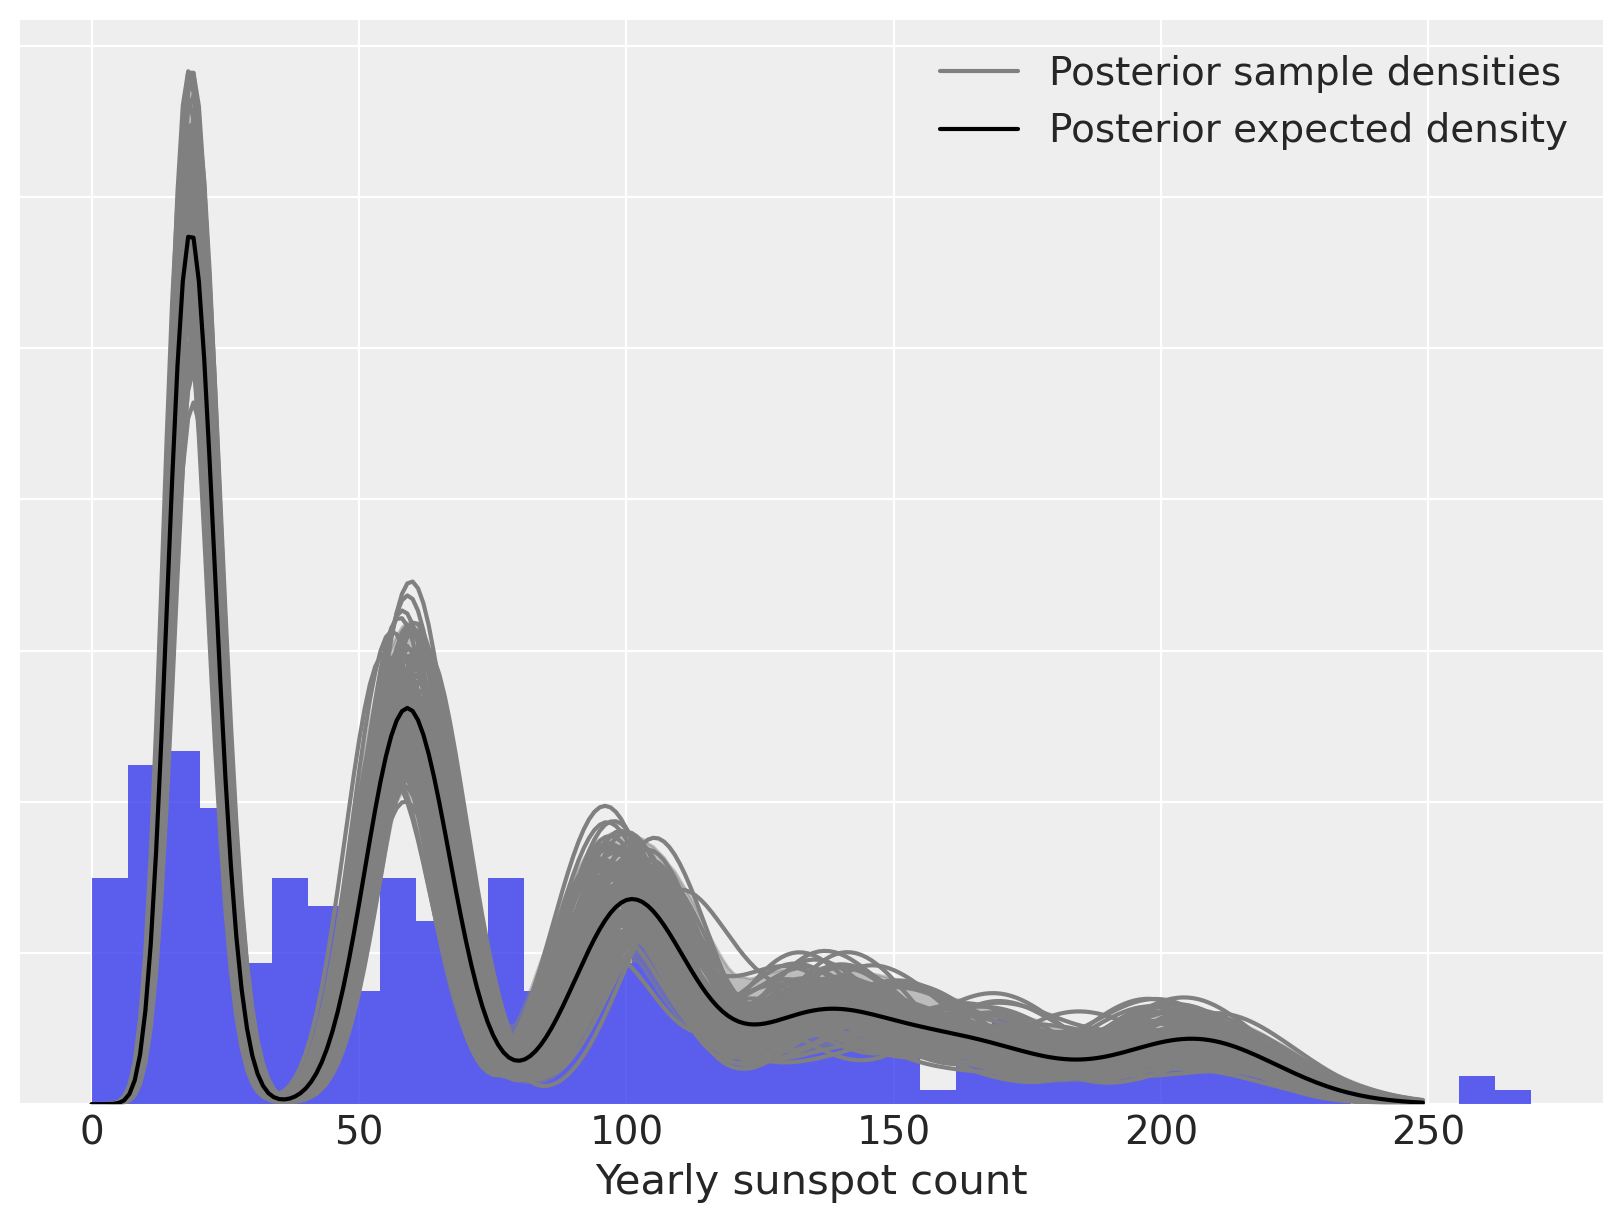

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(sunspot_df["sunspot.year"].values, bins=40, density=True, lw=0, alpha=0.75)

ax.fill_between(
    x_plot,
    post_pmf_quantiles.sel(quantile=0.025),
    post_pmf_quantiles.sel(quantile=0.975),
    color="gray",
    alpha=0.45,
)
ax.plot(x_plot, post_pmfs.sel(chain=0, draw=0), c="gray", label="Posterior sample densities")
ax.plot(
    x_plot,
    az.extract(post_pmfs, var_names="x", num_samples=100),
    c="gray",
)
ax.plot(x_plot, post_pmfs.mean(dim=("chain", "draw")), c="k", label="Posterior expected density")

ax.set_xlabel("Yearly sunspot count")
ax.set_yticklabels([])
ax.legend(loc=1);

Again, we can decompose the posterior expected density into weighted mixture densities.

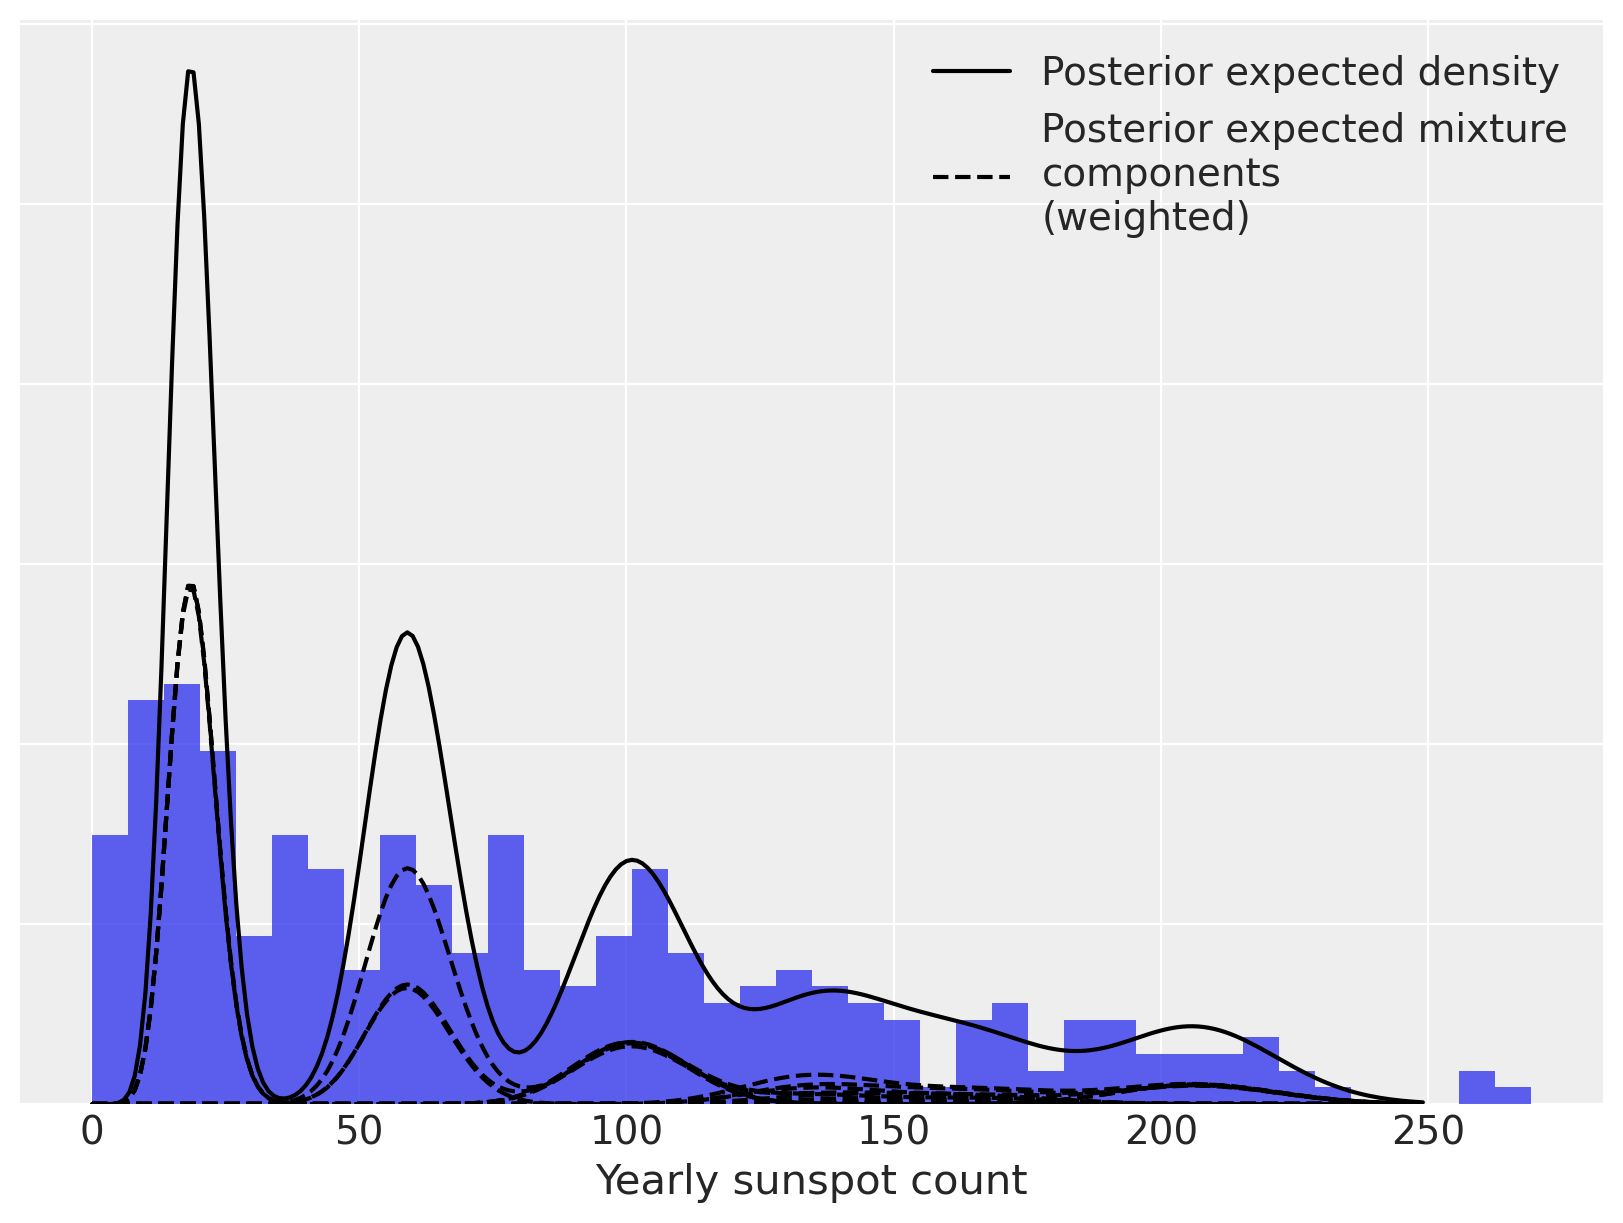

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 40
ax.hist(sunspot_df["sunspot.year"].values, bins=n_bins, density=True, color="C0", lw=0, alpha=0.75)

ax.plot(x_plot, post_pmfs.mean(dim=("chain", "draw")), c="k", label="Posterior expected density")
ax.plot(
    x_plot,
    (trace.posterior["w"] * post_pmf_contribs).mean(dim=("chain", "draw")).sel(component=0),
    "--",
    c="k",
    label="Posterior expected mixture\ncomponents\n(weighted)",
)
ax.plot(
    x_plot,
    (trace.posterior["w"] * post_pmf_contribs).mean(dim=("chain", "draw")).T,
    "--",
    c="k",
)

ax.set_xlabel("Yearly sunspot count")
ax.set_yticklabels([])
ax.legend(loc=1);

## References

:::{bibliography}
:filter: docname in docnames
:::

## Authors
* Adapted by [Austin Rochford](https://github.com/AustinRochford/) from [his own blog post](http://austinrochford.com/posts/2016-02-25-density-estimation-dpm.html)
* Updated by Abhipsha Das on August, 2021 ([pymc-examples#212](https://github.com/pymc-devs/pymc-examples/pull/212))
* Updated to PyMC v5 and to use `az.extract` by [Benjamin T. Vincent](https://github.com/drbenvincent) in February 2023 ([pymc-examples#522](https://github.com/pymc-devs/pymc-examples/pull/522))

## Watermark

In [34]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Feb 06 2023

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.9.0

numpy     : 1.24.1
xarray    : 2023.1.0
pandas    : 1.5.3
matplotlib: 3.6.3
arviz     : 0.14.0
pymc      : 5.0.1
pytensor  : 2.8.11
scipy     : 1.10.0
seaborn   : 0.12.2

Watermark: 2.3.1



:::{include} page_footer.md
:::